<h3> Discretization theory to approximate and infinite square well with a linear term V(x) = alpha x </h3>

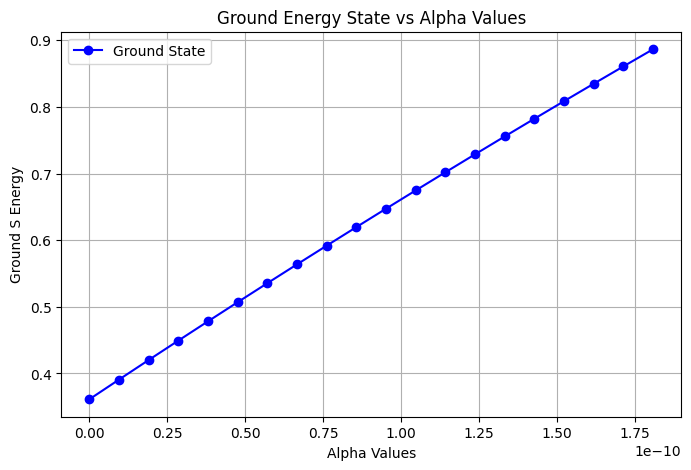

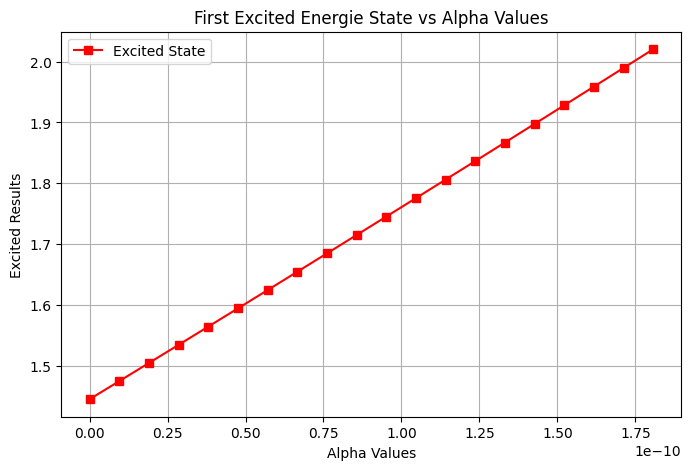

In [28]:
# For linear algebra calculations
import numpy as np
from numpy import linalg as LA

# For constants
import scipy as sci
from scipy import constants

# For plotting
import matplotlib.pyplot as plt

particle_mass = constants.electron_mass # using an electron
well_length = 1e-9

alpha_min = 0
delta_E2 = (3 * (np.pi**2) * (constants.hbar**2)) / (2 * particle_mass * (well_length**2))
alpha_max = delta_E2 / well_length
num_steps = 20
alpha_values = np.linspace(alpha_min, alpha_max, num_steps)

def discretization(L, Steps, m, alpha):
    # define the steo size
    a = L / Steps

    J = constants.hbar**2 / (2 * m * a**2)

    # introduce matrix
    #   ->  -J + 2 * J (diagonal index) - J
    Hamiltonian = [0] * (Steps+1)

    for i in range(Steps+1):
        row = [0] * (Steps+1)

        for j in range(Steps+1):
            if i == j:
                row[j] = 2 * J + V(i, a, alpha)
            if abs(j-i) == 1:
                row[j] = - J
        
        Hamiltonian[i] = row
        
    # calculate eigenvalues
    #   ->  calculate wave function psi_n at each discretization step
    eigenEnergies = LA.eig(Hamiltonian).eigenvalues

    return eigenEnergies

# potential for linear potential increase with linear term (alpha)
def V(n,a,alpha):
    return n * a * alpha

N = 100 # amount of discretized steps per wave-function

groundResults = [] # stores the ground state energies
excitedResults = [] # stores the first excited energies


for alpha in alpha_values:
    singleResult = sorted(discretization(well_length,N,particle_mass,alpha))

    groundResults.append(singleResult[0]/constants.electron_volt)
    excitedResults.append(singleResult[1]/constants.electron_volt)

groundResults = np.array(groundResults)
excitedResults = np.array(excitedResults)

plt.figure(figsize=(8, 5))
plt.plot(alpha_values, groundResults, label='Ground State', color='blue', marker='o')
plt.title('Ground Energy State vs Alpha Values')
plt.xlabel('Alpha Values')
plt.ylabel('Ground S Energy')
plt.grid(True)
plt.legend()

# 2. Create the second figure for Excited Results
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, excitedResults, label='Excited State', color='red', marker='s')
plt.title('First Excited Energie State vs Alpha Values')
plt.xlabel('Alpha Values')
plt.ylabel('Excited Results')
plt.grid(True)
plt.legend()

# Display both windows
plt.show()